# Graph Spectral embedding

**Libraries**

In [2]:
import pandas as pd
import numpy as np
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import Union, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import sknetwork as sk
from sknetwork.visualization import svg_bigraph
from sknetwork.embedding import Spectral, cosine_modularity
from sknetwork.linkpred import JaccardIndex

## 1. Data

In [3]:
path = '/Users/simondelarue/Documents/MS_BGD-Telecom_PARIS/Stage/1_data'

Data comes from [GoodRead Dataset](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/shelves)

In [5]:
%%time
good_read = pd.read_csv(f'{path}/goodreads_interactions.csv')
good_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228648342 entries, 0 to 228648341
Data columns (total 5 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   book_id      int64
 2   is_read      int64
 3   rating       int64
 4   is_reviewed  int64
dtypes: int64(5)
memory usage: 8.5 GB
CPU times: user 1min 28s, sys: 1min, total: 2min 28s
Wall time: 3min 24s


From the orginigal dataset, we build a smaller dataset containing 100 readers, with all the books they've read. Then we divide this smaller dataset into **training** and **test** sub-datasets :
* **training** : contains 80% of the "100 readers" dataset
* **test** : contains 20% of the "100 readers" dataset  

These datasets are then saved in `csv` format.

In [7]:
# 100 readers dataset
good_read_100_users_is_read = good_read[(good_read['user_id']<100) & (good_read['is_read']==1)][]

# Training and test datasets
test_size = 0.2
X_train, X_test = train_test_split(good_read_100_users_is_read, random_state=42, test_size=test_size)

# Save datasets
good_read_100_users_is_read.to_csv(f'{path}/goodreads_interactions_100_users_isread.csv', index=False, header=False)
X_train.to_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', index=False, header=False)
X_test.to_csv(f'{path}/goodreads_interactions_100_users_isread_test.csv', index=False, header=False)

print(f'100 readers dataset size : {good_read_100_users_is_read.shape}')
print(f'Train dataset size : {X_train.shape}')
print(f'Test readers dataset size : {X_test.shape}')

100 readers dataset size : (20159, 3)
Train dataset size : (16127, 3)
Test readers dataset size : (4032, 3)


Split training set into training-evaluation sets.

In [448]:
goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', names=['reader', 'book', 'is_read'])

eval_size = 0.2
X_train, X_eval = train_test_split(goodReads_df, random_state=42, test_size=eval_size)

# Save datasets
X_train.to_csv(f'{path}/goodreads_interactions_100_users_isread_train1.csv', index=False, header=False)
X_eval.to_csv(f'{path}/goodreads_interactions_100_users_isread_eval.csv', index=False, header=False)

## 2. Spectral embedding

Node Spectral embedding is performed on data. For this purpose, we use the **Lanczos** solver to computes *eigenvectors* and *eigenvalues* of (normalized) Laplacian matrix.  
The dimension of the final embedding space is set to $k=20$.  

Computing *eigenvalues* and *eigenvectors* of the normalized Laplacian matrix of the graph is equivalent to computing *eigenvalues* and *eigenvectors* of the transition matrix of a random walk on the graph : 

Let $D$, the diagonal matrix of node's degress  
Let $P=D^{-1}A$, the transition matrix of a random walk on the graph
Let $L=D-A$, the Laplacian matrix of the graph

Solving 
$$
\min_{\substack{X:X^Td=0, X^TDX=I_K}} \sum_{\substack{i,j \in V}}A_{ij}||X_i - X_j||^2
$$
involves the solution of the *generalized* eigen value problem :
$$
LV = DV\Lambda, {\,} V^TDV=I
$$
with $\Lambda = diag(\lambda_1, ..., \lambda_n)$ and $V=D^{-\frac{1}{2}}U$ with $U$ the orthogonal matrix of eigenvectors of the normalized Laplacian matrix of the graph $\bar{L}=D^{-\frac{1}{2}}LD^{-\frac{1}{2}} = I - D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$.

From the above solution, we can write :  

$
\begin{align*}
LV &= DV\Lambda \\
    (D-A)V &= DV\Lambda \\
    D^{-1}DV - D^{-1}AV &= V\Lambda \\
    D^{-1}DV -V\Lambda &= D^{-1}AV \\
    PV &= V(I - \Lambda) \\
\end{align*}
$

So that $V$ is also a matrix of *eigenvectors* of $P$.


**1. Static graph : Perform spectral embedding on training dataset**   

    1.1 Computes spectral node embedding for bipartite graph (using Lanczos solver)  
    1.2 Build specific metrics to evaluate quality of node embedding : Cosine-modularity, embedding divergence (raw or Jaccard), GraphSage
    1.3 Visualize embedding on a few specific nodes

**2. Dynamic graph : Add edges one by on from test dataset**  

    2.1 Naïve approach
        2.1.1 Build the new bipartite graph for each edge added
        2.1.2 Build the new spectral embedding with **random initialization** for each edge added
        2.1.3 Compute embedding evaluation metrics and compare the results to the static results
        2.1.4 Visualize embeddings on a few specific nodes

    2.2 Lanczos initialization  
        2.2.1 Buid the new bipartite graph for each edge added
        2.2.2 Build the new spectral embedding with **previous embedding step initialization** for each edge added
        2.1.3 Compute embedding evaluation metrics and compare the results to the static results
        2.1.4 Visualize embeddings on a few specific nodes

    2.3. Perform previous steps on much larger dataset  

**3. Add a evaluation task into the process :**  

    3.1 Perform clustering on static graph
    3.2 After each embedding step on dynamic graph, perform clustering and compare results to static clustering results
    3.2.1 KMeans clustering
    3.2.2 Louvain algorithm

### 2.1 Static graph

Preliminary analysis is performed on the static graph coming from training dataset. To build the bipartite graph, data is stored in a **CSR format** using `scikit-network` library.

#### 2.1.1 Build graph

In [4]:
%%time
goodReads = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train.csv', bipartite=True, fast_format=False)

CPU times: user 58.9 ms, sys: 5.38 ms, total: 64.3 ms
Wall time: 64 ms


In [5]:
biadjacency = goodReads.biadjacency
readers = goodReads.names
books = goodReads.names_col

# Biadjacency matrix in CSR format
biadjacency

<100x11253 sparse matrix of type '<class 'numpy.float64'>'
	with 16127 stored elements in Compressed Sparse Row format>

In [6]:
print(f'# of readers = {len(np.unique(readers))}')
print(f'# of books   = {len(np.unique(books))}')

# of readers = 100
# of books   = 11253


Let's draw the bipartite graph for people that read less than $k$ books only.

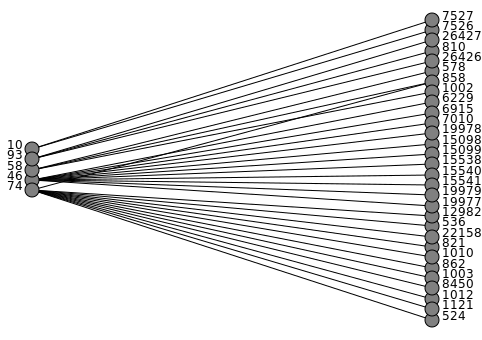

In [7]:
k = 15

goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', header=None, names=['reader_id', 'book_id', 'value'])
goodReads_df.groupby('reader_id').filter(lambda x: x['value'].count() < k).to_csv(f'{path}/goodreads_interactions_few_users.csv', index=False, header=False)
goodReads_to_plot = sk.data.load_edge_list(f'{path}/goodreads_interactions_few_users.csv', bipartite=True, fast_format=False)

# Plot graph
image = svg_bigraph(goodReads_to_plot.biadjacency, names_row=goodReads_to_plot.names, names_col=goodReads_to_plot.names_col)
SVG(image)

**Node degree distribution**  

We compute the node degree distribution for the training and test datasets, but also on the whole dataset, in order to have an intuition about the metrics for the real-world problem.

CPU times: user 8min 42s, sys: 5min 4s, total: 13min 46s
Wall time: 20min 4s


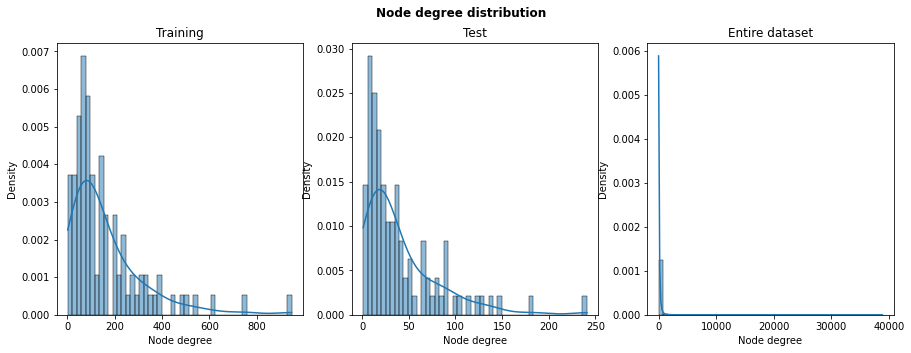

In [54]:
%%time 

# Training and test datasets
datasets = {'Training':'_100_users_isread_train', 'Test':'_100_users_isread_test', 'Entire dataset':'_isread'}

# Plots
fig, ax = plt.subplots(1, len(datasets), figsize=(15, 5))
plt.suptitle('Node degree distribution', weight='bold')

for idx, (k, v) in enumerate(datasets.items()):

    # Load data
    g_ = sk.data.load_edge_list(f'{path}/goodreads_interactions{v}.csv', bipartite=True, fast_format=False)
    biadj = g_.biadjacency

    # Plot node degree distribution
    sns.histplot(biadj.dot(np.ones(biadj.shape[1])), kde=True, stat='density', bins=50, ax=ax[idx]);
    ax[idx].set_xlabel('Node degree')
    ax[idx].set_title(f'{k}');


#### 2.1.2 Build spectral embedding

Let's build spectral embedding by computing *eigenvalues* and *eigenvectors* of normalized Laplacian matrix. We keep only $k$ highest *eigenvectors* for the embedding (the choice of $k$ can of course be criticized).  
**Lanczos** algorithm is used.

Size of readers embedding : (100, 20)
Size of books embedding   : (11253, 20)


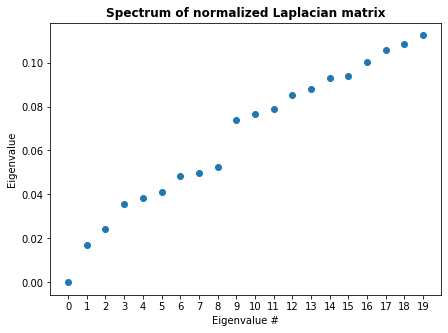

In [8]:
k = 20 # Embedding dimension

# Normalized embedding
bispectral_norm = Spectral(k, normalized_laplacian=True, regularization=0)
embedding_readers_norm = bispectral_norm.fit_transform(biadjacency)
embedding_books_norm = bispectral_norm.embedding_col_
eigvalues_norm = bispectral_norm.eigenvalues_

print(f'Size of readers embedding : {embedding_readers_norm.shape}')
print(f'Size of books embedding   : {embedding_books_norm.shape}')

# Plot spectrum

def print_spectrum(eigvalues, ax, normalized=True):
    ax.scatter(range(len(eigvalues)), eigvalues)
    if normalized:
        ax.set_title('Spectrum of normalized Laplacian matrix', weight='bold')
    else:
        ax.set_title('Spectrum of Laplacian matrix', weight='bold')
    ax.set_xticks(np.arange(0, len(eigvalues)))
    ax.set_xlabel('Eigenvalue #')
    ax.set_ylabel('Eigenvalue');

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
print_spectrum(eigvalues_norm, ax)

**COSINE MODULARITY**  

For bipartite graph, **cosine-modularity** $Q$ is defined as :  
$$
Q = \sum_{i,j}\biggl( \dfrac{B_{i,j}}{w} - \gamma \dfrac{w_{1,i}w_{2,j}}{w^2} \biggl) \biggl( \dfrac{1+cos(x_i, y_i)}{2} \biggl)
$$  

where :
* $w_{1,i}$, $w_{2,j}$ are the weights of nodes $i$ (row) and $j$ (column)
* $w = 1^TB1$ is the total weight of the graph  
* $x$ and $y$ the embeddings of rows and columns respectively

Source : [Scikit-network documentation](https://scikit-network.readthedocs.io/en/latest/reference/embedding.html?highlight=modularity#sknetwork.embedding.cosine_modularity)

In [11]:
cosine_mod_norm = np.round(cosine_modularity(biadjacency, embedding=embedding_readers_norm, embedding_col=embedding_books_norm), 3)
print(f'Cosine modularity of normalized embedding : {cosine_mod_norm}')

Cosine modularity of normalized embedding : 0.436


**Embedding cosine-modularity variance**

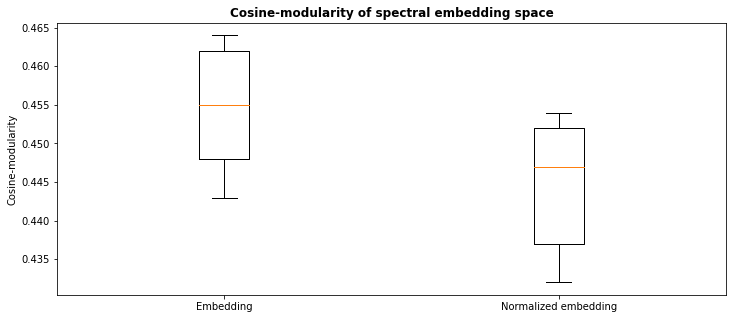

In [30]:
k = 20
cosmod_iter_list, cosmod_iter_list_norm = [], []

# 100 iterations
for i in range(100):
    spect = Spectral(k, normalized_laplacian=False, regularization=0)
    spect_norm = Spectral(k, normalized_laplacian=True, regularization=0)
    
    embed_rows = spect.fit_transform(biadjacency)
    embed_cols = spect.embedding_col_
    embed_rows_norm = spect_norm.fit_transform(biadjacency)
    embed_cols_norm = spect_norm.embedding_col_
    
    cosmod_iter_list.append(np.round(cosine_modularity(biadjacency, embedding=embed_rows, embedding_col=embed_cols), 3))
    cosmod_iter_list_norm.append(np.round(cosine_modularity(biadjacency, embedding=embed_rows_norm, embedding_col=embed_cols_norm), 3))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.boxplot([cosmod_iter_list, cosmod_iter_list_norm], labels=['Embedding', 'Normalized embedding'])
plt.ylabel('Cosine-modularity')
plt.title('Cosine-modularity of spectral embedding space', weight='bold');

**Varying $k$, the embedding size**  

It can be interesting to observe the evolution of cosine modularity of embedding, according to the value of $k$ - the dimension of the embedding. For spectral embedding, we can assume that if $k=n$ (with $n$ the number of vertices), the embedding will capture all the structural information.

CPU times: user 25min, sys: 48.4 s, total: 25min 49s
Wall time: 13min 23s


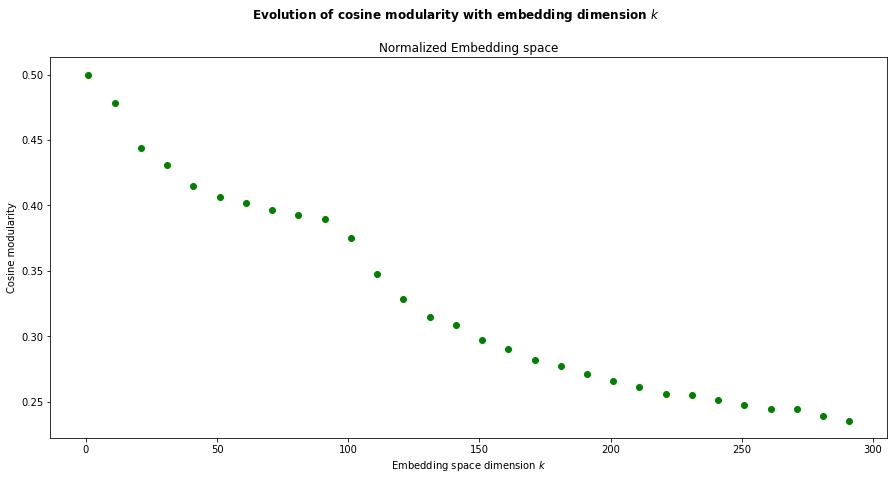

In [33]:
%%time

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
fig.suptitle('Evolution of cosine modularity with embedding dimension $k$', weight='bold')
plt.title('Normalized Embedding space');
plt.xlabel('Embedding space dimension $k$')
plt.ylabel('Cosine modularity');

nb_iter = 5
k = biadjacency.shape[1]
list_k = np.arange(1, 300, 10) # Embedding dimension
avg_cosine_mod_norm, elapsed_times = [], []
verbose = False # Displays information when processing if True

for k in list_k:
    start = time.time()
    if verbose: print(f'Computing spectral embedding for k = {k} ...')
    
    list_cosine_mod_norm = []
    for i in range(nb_iter):
        # Normalized embedding
        # bispectral_norm = BiSpectral(k, normalized=True, regularization=0, scaling=0, solver='lanczos')
        bispectral_norm = Spectral(k, normalized_laplacian=True, regularization=0)
        emb_norm = bispectral_norm.fit_transform(biadjacency)

        # Cosine modularity
        cos_mod = cosine_modularity(biadjacency, embedding=emb_norm, embedding_col=bispectral_norm.embedding_col_)
        list_cosine_mod_norm.append(cos_mod)
    
    avg_cosine_mod = np.mean(list_cosine_mod_norm)
    avg_cosine_mod_norm.append(avg_cosine_mod) # Save values in list
    
    end = time.time()
    elapsed_time = end - start
    elapsed_times.append(elapsed_time) # Save times in list
    if verbose: print(f'   Done ! Average cosine-modularity = {avg_cosine_mod:.3f} ({(elapsed_time):.4f}s)')
    
    # Plot
    plt.scatter(k, avg_cosine_mod, color='g')

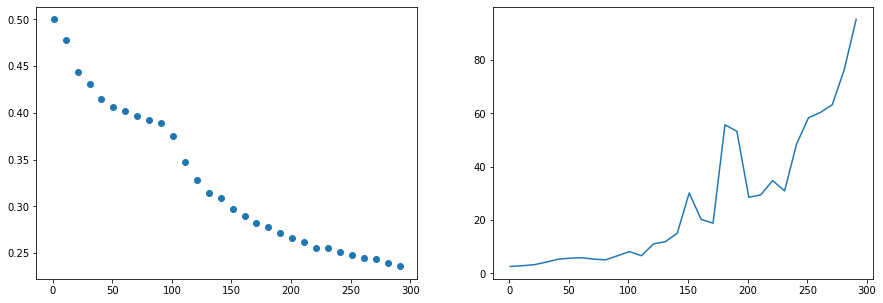

In [34]:
# Scikit-network 0.24.0
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(list_k[:len(avg_cosine_mod_norm)], avg_cosine_mod_norm)
ax[1].plot(list_k[:len(elapsed_times)], elapsed_times);

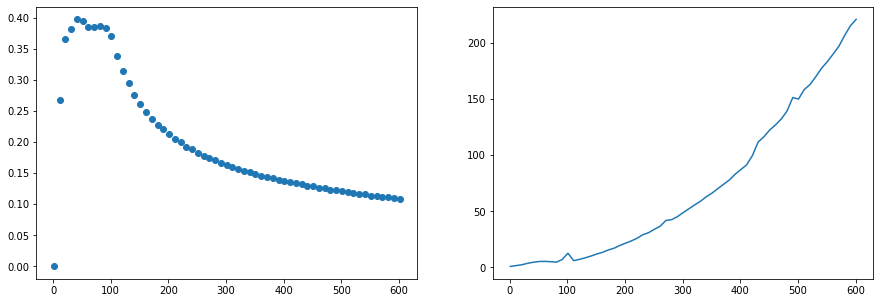

In [78]:
# Scikit-network 0.23.1
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(list_k[:len(avg_cosine_mod_norm)], avg_cosine_mod_norm)
ax[1].plot(list_k[:len(elapsed_times)], elapsed_times);

In [ ]:
%%time
bispectral_norm = BiSpectral(biadjacency.shape[1], normalized=True, regularization=0, scaling=0, solver='lanczos')
emb_norm = bispectral_norm.fit_transform(biadjacency)
print('Embedding computed')
cos_mod = cosine_modularity(biadjacency, embedding=emb_norm, embedding_col=bispectral_norm.embedding_col_)

**EMBEDDING DIVERGENCE**  

We compute divergence metric between initial network topology and spectral embedding result. Two different versions of divergence are implemented : 

* **Raw divergence** : 
$$
Q^{r}_{i, j} = | B_{i, j} - X_{i}X_{j}^T |
$$
with $B$ is the biadjacency matrix and $X$ the embedding space.

* **Jaccard divergence** : 
$$
Q^{J}_{i, j} = | J_{i, j} - X_{i}X_{j}^T |
$$
with $J_{i}$ the Jaccard index value for node $i$

**Raw divergence**

In [9]:
def raw_divergence(biadjacency, embedding, embedding_col=None):
    #return (np.abs(biadjacency - embedding.dot(embedding_col.T)).sum().sum()) / (biadjacency.shape[0]*biadjacency.shape[1])
    return (np.abs(biadjacency).sum().sum() / (biadjacency.shape[0]*biadjacency.shape[1])), (np.abs(embedding.dot(embedding_col.T)).sum().sum() / (biadjacency.shape[0]*biadjacency.shape[1])) 

def jaccard_divergence(biadjacency, nodes, embedding):
    jaccard_index = JaccardIndex()
    similarities = jaccard_index.fit_predict(biadjacency, nodes)
    #return (np.abs(similarities - embedding.dot(embedding.T)).sum().sum()) / (biadjacency.shape[0]*biadjacency.shape[1])
    return (np.abs(similarities).sum().sum() / (biadjacency.shape[0]*biadjacency.shape[1])), (np.abs(embedding.dot(embedding.T)).sum().sum() / (biadjacency.shape[0]*biadjacency.shape[1])) 

In [36]:
# Raw divergence
Q_r = np.abs(biadjacency - embedding_readers_norm.dot(embedding_books_norm.T))
print(Q_r.shape)

(100, 11253)


Let's verify that for a specific node, the raw divergence is minimized in the embedding space for neighbor nodes in the originial graph.

In [68]:
node = 10 # 10, 93, 58, 46, 74

print(f' Reader {node}\'s books : {books[sk.utils.get_neighbors(biadjacency, node)]}')
print(f' Reader {node} :  Divergence minimized for books {books[np.argsort(Q_r[node, :])[:, :5]]}')
print(f' Reader {node} minimal divergence : {np.sort(Q_r[node, :])[:, :5]}')

 Reader 10's books : [7526 7527]
 Reader 10 :  Divergence minimized for books [[18389 18400 12236 18311 18366]]
 Reader 10 minimal divergence : [[0.00131555 0.00131555 0.00131555 0.00131555 0.00131555]]


**Jaccard divergence**

In [66]:
# Similarity matrix
jaccard_index = JaccardIndex()
similarities = jaccard_index.fit_predict(biadjacency, readers)

# Jaccard divergence
Q_j = np.abs(similarities - embedding_readers_norm.dot(embedding_readers_norm.T))
print(Q_j.shape)

(100, 100)


In [69]:
node = 93 # 10, 93, 58, 46, 74

print(f' Reader {node}\'s books : {books[sk.utils.get_neighbors(biadjacency, node)]}')
print(f' Reader {node} :  Divergence minimized with readers {readers[np.argsort(Q_j[node, :])[:5]]}')
print(f' Reader {node} minimal divergence : {np.sort(Q_j[node, :])[:5]}')

 Reader 93's books : [  810 26426 26427]
 Reader 93 :  Divergence minimized with readers [66 12 41 78 63]
 Reader 93 minimal divergence : [7.18238572e-07 1.26002752e-06 2.54973801e-06 3.00224564e-06
 4.45369553e-06]


### 2.2 Dynamic graph

#### 2.2.1 Naïve approach

For every new edge incoming, the previous graph is updated by :  
* updating `csv` file containing all edges
* computing the **CSR matrix** corresponding to the updated graph
* computing the new spectral embedding with **random initialization**

In [5]:
def add_link(df, link):
    
    new_source, new_target = None, None
    
    if link.iloc[0, 0] not in df.iloc[:, 0].values:
        new_source = link.iloc[0, 0]
    if link.iloc[0, 1] not in df.iloc[:, 1].values:
        new_target = link.iloc[0, 1]
        
    updated_df = pd.concat([df, link], axis=0)
    updated_df.to_csv(f'{path}/updated_df.csv', index=False, header=False)

    return updated_df, new_source, new_target

In [240]:
%%time

k = 20 # Embedding space dimension
list_cosmod, list_raw_div, list_jaccard_div = [], [], []

# - Import Data -
goodReads = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train.csv', bipartite=True, fast_format=False)
goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', names=['reader', 'book', 'is_read'])
goodReads_new_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_test.csv', names=['reader', 'book', 'is_read'])


# - Initial embedding -
init_biadjacency = goodReads.biadjacency
init_readers = goodReads.names
init_books = goodReads.names_col

init_bispectral_norm = Spectral(k, normalized_laplacian=True, regularization=0)
init_embedding_readers_norm = init_bispectral_norm.fit_transform(init_biadjacency)
init_embedding_books_norm = init_bispectral_norm.embedding_col_

# - Embedding metrics -

# Cosine-modularity
init_cosine_mod_norm = cosine_modularity(init_biadjacency, 
                                                     embedding=init_embedding_readers_norm, 
                                                     embedding_col=init_embedding_books_norm)
list_cosmod.append(init_cosine_mod_norm) # Fill cosine similarity list

# Raw divergence
init_raw_div = raw_divergence(init_biadjacency, 
                                       init_embedding_readers_norm, 
                                       init_embedding_books_norm)
list_raw_div.append(init_raw_div) # Fill raw divergence list

# Jaccard divergence
init_jaccard_div = jaccard_divergence(init_biadjacency,
                                               init_readers,
                                               init_embedding_readers_norm)
list_jaccard_div.append(init_jaccard_div) # Fill jaccard divergence list




# - Initialization -
updated_df = goodReads_df.copy()

# - Add new nodes -
list_biadjacency, list_embed_readers, diff_list_embed_readers = [], [], []
for i in range(int(goodReads_new_df.shape[0]/10)):
    
    link = goodReads_new_df.iloc[i:i+1, :]
    updated_df, _, _ = add_link(updated_df, link)
        
    # Update graph
    updated_graph = sk.data.load_edge_list(f'{path}/updated_df.csv', bipartite=True, fast_format=False)
    
    # Update Embedding
    updated_biadjacency = updated_graph.biadjacency
    updated_readers = updated_graph.names
    updated_books = updated_graph.names_col
    
    updated_bispectral_norm = Spectral(k, normalized_laplacian=True, regularization=0)
    updated_embedding_readers_norm = updated_bispectral_norm.fit_transform(updated_biadjacency)
    updated_embedding_books_norm = updated_bispectral_norm.embedding_col_
    
    # Update embedding metrics
    updated_cosine_mod_norm = cosine_modularity(updated_biadjacency, 
                                                         embedding=updated_embedding_readers_norm, 
                                                         embedding_col=updated_embedding_books_norm)
    list_cosmod.append(updated_cosine_mod_norm) # Fill cosine similarity list
    
    updated_raw_div = raw_divergence(updated_biadjacency,
                                         updated_embedding_readers_norm,
                                         updated_embedding_books_norm)
    list_raw_div.append(updated_raw_div) # Fill raw divergence list
    
    updated_jaccard_div = jaccard_divergence(updated_biadjacency,
                                         updated_readers,
                                         updated_embedding_readers_norm)
    list_jaccard_div.append(updated_jaccard_div) # Fill jaccard divergence list
    
    #if i%100 == 0:
    #    list_biadjacency.append(updated_biadjacency)
    #    list_embed_readers.append(updated_embedding_readers_norm)
    list_biadjacency.append(updated_biadjacency)
    list_embed_readers.append(updated_embedding_readers_norm)
    
    # Evalute stability
    if i > 0:
        # Froebinus norm between embedding at time t+1 and embedding at time t
        diff_list_embed_readers.append(np.linalg.norm(list_embed_readers[i] - list_embed_readers[i-1], 
                                                      ord='fro'))

CPU times: user 10min 39s, sys: 1min 18s, total: 11min 58s
Wall time: 6min 8s


In [41]:
%%time

k = 20 # Embedding space dimension
list_raw_div_B, list_raw_div_X = [], []
list_jaccard_div_B, list_jaccard_div_X = [], []
list_cosim, list_cosim_j = [], []

# - Import Data -
goodReads = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train.csv', bipartite=True, fast_format=False)
goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', names=['reader', 'book', 'is_read'])
goodReads_new_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_test.csv', names=['reader', 'book', 'is_read'])


# - Initial embedding -
init_biadjacency = goodReads.biadjacency
init_readers = goodReads.names
init_books = goodReads.names_col

init_bispectral_norm = Spectral(k, normalized_laplacian=True, regularization=0)
init_embedding_readers_norm = init_bispectral_norm.fit_transform(init_biadjacency)
init_embedding_books_norm = init_bispectral_norm.embedding_col_

# - Embedding metrics -

# Cosine similarity
cosim_div = np.abs(init_biadjacency - cosine_similarity(init_embedding_readers_norm, init_embedding_books_norm)).sum().sum() / (init_biadjacency.shape[0]*init_biadjacency.shape[1])
list_cosim.append(cosim_div)



# Raw divergence
init_raw_div_B, init_raw_div_X = raw_divergence(init_biadjacency, 
                                       init_embedding_readers_norm, 
                                       init_embedding_books_norm)
list_raw_div_B.append(init_raw_div_B) # Fill raw divergence list
list_raw_div_X.append(init_raw_div_X) # Fill raw divergence list

# Jaccard divergence
init_jaccard_div_B, init_jaccard_div_X = jaccard_divergence(init_biadjacency,
                                               init_readers,
                                               init_embedding_readers_norm)
list_jaccard_div_B.append(init_jaccard_div_B) # Fill jaccard divergence list
list_jaccard_div_X.append(init_jaccard_div_X) # Fill jaccard divergence list




# - Initialization -
updated_df = goodReads_df.copy()

# - Add new nodes -
list_biadjacency, list_embed_readers, diff_list_embed_readers = [], [], []
for i in range(int(goodReads_new_df.shape[0]/20)):
    
    link = goodReads_new_df.iloc[i:i+1, :]
    updated_df, _, _ = add_link(updated_df, link)
        
    # Update graph
    updated_graph = sk.data.load_edge_list(f'{path}/updated_df.csv', bipartite=True, fast_format=False)
    
    # Update Embedding
    updated_biadjacency = updated_graph.biadjacency
    updated_readers = updated_graph.names
    updated_books = updated_graph.names_col
    
    updated_bispectral_norm = Spectral(k, normalized_laplacian=True, regularization=0)
    updated_embedding_readers_norm = updated_bispectral_norm.fit_transform(updated_biadjacency)
    updated_embedding_books_norm = updated_bispectral_norm.embedding_col_
    
    
    updated_cosim_div = np.abs(updated_biadjacency - cosine_similarity(updated_embedding_readers_norm, updated_embedding_books_norm)).sum().sum() / (updated_biadjacency.shape[0]*updated_biadjacency.shape[1])
    list_cosim.append(updated_cosim_div)
    

    
    updated_raw_div_B, updated_raw_div_X = raw_divergence(updated_biadjacency,
                                         updated_embedding_readers_norm,
                                         updated_embedding_books_norm)
    list_raw_div_B.append(updated_raw_div_B) # Fill raw divergence list
    list_raw_div_X.append(updated_raw_div_X) # Fill raw divergence list
    
    updated_jaccard_div_B, updated_jaccard_div_X = jaccard_divergence(updated_biadjacency,
                                         updated_readers,
                                         updated_embedding_readers_norm)
    list_jaccard_div_B.append(updated_jaccard_div_B) # Fill jaccard divergence list
    list_jaccard_div_X.append(updated_jaccard_div_X) # Fill jaccard divergence list
    
    #if i%100 == 0:
    #    list_biadjacency.append(updated_biadjacency)
    #    list_embed_readers.append(updated_embedding_readers_norm)
    list_biadjacency.append(updated_biadjacency)
    list_embed_readers.append(updated_embedding_readers_norm)
    
    # Evalute stability
    if i > 0:
        # Froebinus norm between embedding at time t+1 and embedding at time t
        diff_list_embed_readers.append(np.linalg.norm(list_embed_readers[i] - list_embed_readers[i-1], 
                                                      ord='fro'))

CPU times: user 5min 8s, sys: 10.8 s, total: 5min 19s
Wall time: 2min 46s


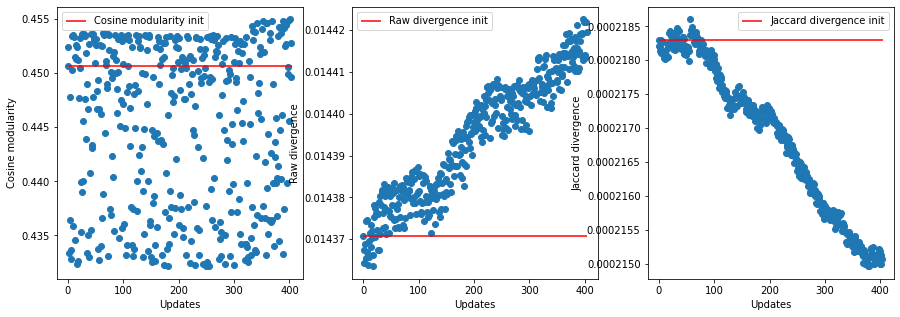

In [106]:
metrics = {'Cosine modularity':list_cosmod, 
           'Raw divergence':list_raw_div, 
           'Jaccard divergence':list_jaccard_div}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    ax[idx].scatter(range(len(v)), v)
    ax[idx].hlines(y=v[0], xmin=0, xmax=len(v), label=f'{k} init', color='r')
    ax[idx].set_xlabel('Updates')
    ax[idx].set_ylabel(f'{k}')
    ax[idx].legend(loc='best');

The problem with these divergence metrics is that the left part of the subtraction, i.e the evolution of the initial graph itself (before embedding) is driving the tendency all by itself.

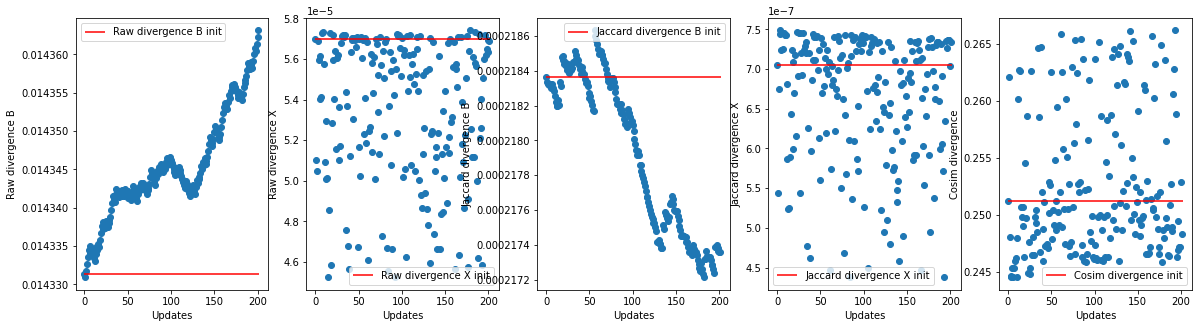

In [42]:
metrics = {'Raw divergence B':list_raw_div_B, 
           'Raw divergence X':list_raw_div_X, 
           'Jaccard divergence B':list_jaccard_div_B,
           'Jaccard divergence X':list_jaccard_div_X,
           'Cosim divergence':list_cosim}

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for idx, (k, v) in enumerate(metrics.items()):
    ax[idx].scatter(range(len(v)), v)
    ax[idx].hlines(y=v[0], xmin=0, xmax=len(v), label=f'{k} init', color='r')
    ax[idx].set_xlabel('Updates')
    ax[idx].set_ylabel(f'{k}')
    ax[idx].legend(loc='best');

**$\Delta$ in metrics**  

These plots reflect the stability of correlation between initial network and embeddings.

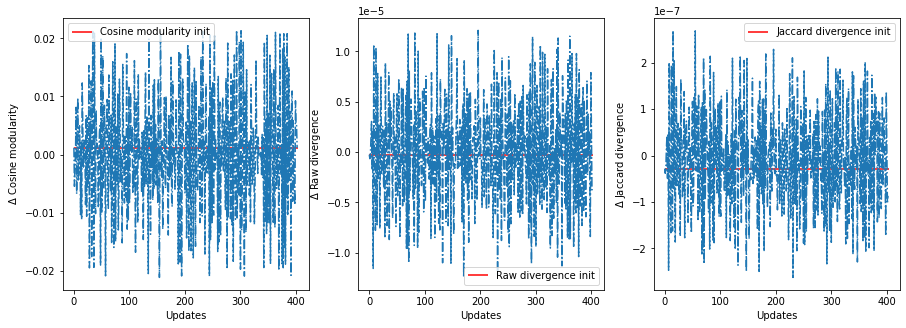

In [249]:
delta_list_cosmod = np.array(list_cosmod[1:]) - np.array(list_cosmod[:-1])
delta_list_raw_div = np.array(list_raw_div[1:]) - np.array(list_raw_div[:-1])
delta_list_jaccard_div = np.array(list_jaccard_div[1:]) - np.array(list_jaccard_div[:-1])

metrics = {'Cosine modularity':delta_list_cosmod, 
           'Raw divergence':delta_list_raw_div, 
           'Jaccard divergence':delta_list_jaccard_div}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    ax[idx].plot(range(len(v)), v, linestyle='dashdot')
    ax[idx].hlines(y=v[0], xmin=0, xmax=len(v), label=f'{k} init', color='r')
    ax[idx].set_xlabel('Updates')
    ax[idx].set_ylabel(f'$\Delta$ {k}')
    ax[idx].legend(loc='best');

**Embedding's variations**

Embedding's variations are defined by $\Delta_{t}$ : 
$$
\Delta_{t} = || E_{t+1} - E_{t} ||_F
$$
with $||A||_F = (\sum_{i,j}a_{i,j}^2)^{\frac{1}{2}}$

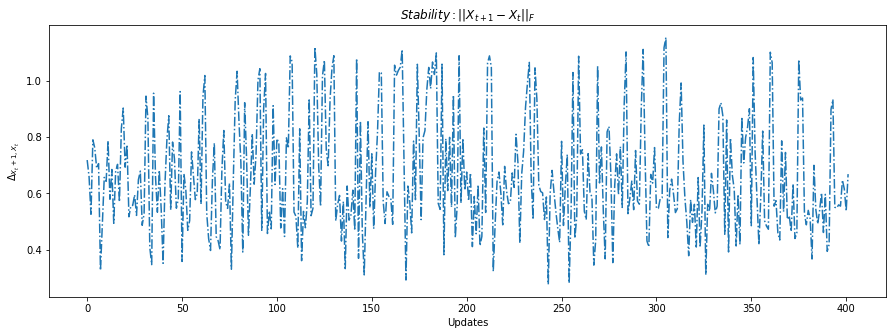

In [125]:
metrics = {'Stability':diff_list_embed_readers}

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    plt.plot(range(len(v)), v, linestyle='dashdot')
    plt.xlabel('Updates')
    plt.ylabel('$\Delta_{X_t+1, X_t}$')
    plt.title('$Stability : ||X_{t+1} - X_{t}||_{F}$', weight='bold');

Embedding stability variance : 0.042


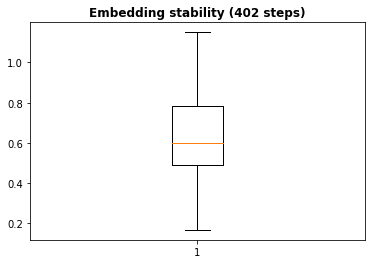

In [243]:
print(f'Embedding stability variance : {np.var(diff_list_embed_readers):.3f}')
plt.boxplot(diff_list_embed_readers)
plt.title(f'Embedding stability ({len(diff_list_embed_readers)} steps)', weight='bold');

#### 2.2.2 Lanczos with $X_{t-1}$ initialization

The lanczos algorithm is not initialized with a random vector, but rather with the **first eigenvector** of the embedding $X$ at step $t-1$.

In [274]:
k=20
list_cosmod_lanc, list_raw_div_lanc, list_jaccard_div_lanc, list_v0 = [], [], [], []

# - Initial embedding -
init_biadjacency = goodReads.biadjacency
init_readers = goodReads.names
init_books = goodReads.names_col

init_bispectral_lanc = Spectral(k, normalized_laplacian=True, regularization=0, v0=None)
init_embedding_readers_lanc = init_bispectral_lanc.fit_transform(init_biadjacency)
init_embedding_books_lanc = init_bispectral_lanc.embedding_col_

init_first_embed_readers = init_embedding_readers_lanc[:, 0]
init_first_embed_books = init_embedding_books_lanc[:, 0]
list_v0.append(np.hstack([init_first_embed_readers, init_first_embed_books]))

In [275]:
%%time

# - Import Data -
goodReads = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train.csv', bipartite=True, fast_format=False)
goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', names=['reader', 'book', 'is_read'])
goodReads_new_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_test.csv', names=['reader', 'book', 'is_read'])

# - Initialization -
updated_df_lanc = goodReads_df.copy()
updated_readers_lanc = init_readers
updated_books_lanc = init_books
updated_first_embed_readers = init_first_embed_readers
updated_first_embed_books = init_first_embed_books


# - Add new nodes -
list_biadjacency_lanc, list_embed_readers_lanc, diff_list_embed_readers_lanc = [], [], []
for i in range(int(goodReads_new_df.shape[0]/10)):
    
    link = goodReads_new_df.iloc[i:i+1, :]
    updated_df_lanc, new_source, new_target = add_link(updated_df_lanc, link)
    
    # Previous step embedding vector
    if new_source != None:
        j = 0
        while updated_readers_lanc[j] < new_source:
            j += 1
        updated_first_embed_readers = np.insert(updated_first_embed_readers, j, 0)
    if new_target != None:
        j = 0
        while updated_books_lanc[j] < new_target:
            j += 1
        updated_first_embed_books = np.insert(updated_first_embed_books, j, 0)
    # Update v0 at time t-1 to fit with adjacency matrix at time t
    list_v0[i] = np.hstack([updated_first_embed_readers, updated_first_embed_books])
        
    # Update graph
    updated_graph_lanc = sk.data.load_edge_list(f'{path}/updated_df.csv', bipartite=True, fast_format=False)
    
    # Update Embedding
    updated_biadjacency_lanc = updated_graph_lanc.biadjacency
    updated_readers_lanc = updated_graph_lanc.names
    updated_books_lanc = updated_graph_lanc.names_col

    updated_bispectral_lanc = Spectral(k, 
                                       normalized_laplacian=True, 
                                       regularization=0, 
                                       v0=list_v0[i])
    updated_embedding_readers_lanc = updated_bispectral_lanc.fit_transform(updated_biadjacency_lanc)    
    updated_embedding_books_lanc = updated_bispectral_lanc.embedding_col_
    
    # Update v0 at time t with new embedding information
    updated_first_embed_readers = updated_embedding_readers_lanc[:, 0]
    updated_first_embed_books = updated_embedding_books_lanc[:, 0]
    list_v0.append(np.hstack([updated_first_embed_readers, updated_first_embed_books]))
    
    
    # Update embedding metrics
    updated_cosine_mod_lanc = cosine_modularity(updated_biadjacency_lanc, 
                                                         embedding=updated_embedding_readers_lanc, 
                                                         embedding_col=updated_embedding_books_lanc)
    list_cosmod_lanc.append(updated_cosine_mod_lanc) # Fill cosine similarity list
    
    updated_raw_div_lanc = raw_divergence(updated_biadjacency_lanc,
                                         updated_embedding_readers_lanc,
                                         updated_embedding_books_lanc)
    list_raw_div_lanc.append(updated_raw_div_lanc) # Fill raw divergence list
    
    updated_jaccard_div_lanc = jaccard_divergence(updated_biadjacency_lanc,
                                         updated_readers_lanc,
                                         updated_embedding_readers_lanc)
    list_jaccard_div_lanc.append(updated_jaccard_div_lanc) # Fill jaccard divergence list
    
    #if i%100 == 0:
    #    list_biadjacency.append(updated_biadjacency)
    #    list_embed_readers.append(updated_embedding_readers_norm)
    list_biadjacency_lanc.append(updated_biadjacency_lanc)
    list_embed_readers_lanc.append(updated_embedding_readers_lanc)
    
    # Evalute stability
    if i > 0:
        # Froebinus norm between embedding at time t+1 and embedding at time t
        diff_list_embed_readers_lanc.append(np.linalg.norm(list_embed_readers_lanc[i] - list_embed_readers_lanc[i-1], 
                                                      ord='fro'))

CPU times: user 10min 10s, sys: 1min 15s, total: 11min 26s
Wall time: 5min 43s


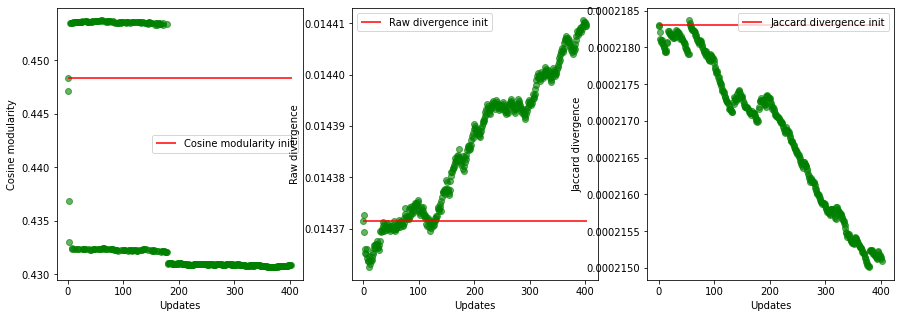

In [278]:
metrics = {'Cosine modularity':list_cosmod_lanc, 
           'Raw divergence':list_raw_div_lanc, 
           'Jaccard divergence':list_jaccard_div_lanc}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    ax[idx].scatter(range(len(v)), v, color='g', alpha=0.6)
    ax[idx].hlines(y=v[0], xmin=0, xmax=len(v), label=f'{k} init', color='r')
    ax[idx].set_xlabel('Updates')
    ax[idx].set_ylabel(f'{k}')
    ax[idx].legend(loc='best');

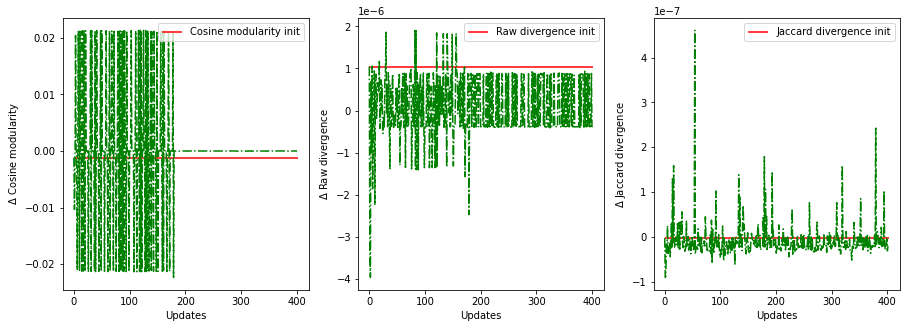

In [279]:
delta_list_cosmod_lanc = np.array(list_cosmod_lanc[1:]) - np.array(list_cosmod_lanc[:-1])
delta_list_raw_div_lanc = np.array(list_raw_div_lanc[1:]) - np.array(list_raw_div_lanc[:-1])
delta_list_jaccard_div_lanc = np.array(list_jaccard_div_lanc[1:]) - np.array(list_jaccard_div_lanc[:-1])

metrics = {'Cosine modularity':delta_list_cosmod_lanc, 
           'Raw divergence':delta_list_raw_div_lanc, 
           'Jaccard divergence':delta_list_jaccard_div_lanc}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    ax[idx].plot(range(len(v)), v, linestyle='dashdot', color='g')
    ax[idx].hlines(y=v[0], xmin=0, xmax=len(v), label=f'{k} init', color='r')
    ax[idx].set_xlabel('Updates')
    ax[idx].set_ylabel(f'$\Delta$ {k}')
    ax[idx].legend(loc='best');

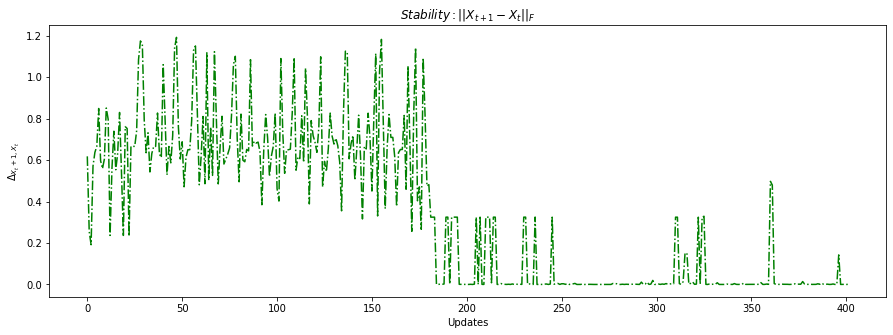

In [280]:
metrics = {'Stability':diff_list_embed_readers_lanc}

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    plt.plot(range(len(v)), v, linestyle='dashdot', color='g')
    plt.xlabel('Updates')
    plt.ylabel('$\Delta_{X_t+1, X_t}$')
    plt.title('$Stability : ||X_{t+1} - X_{t}||_{F}$', weight='bold');

**Static vs dynamic embedding stability variance**

Static Embedding stability variance : 0.042
Dynamic Embedding stability variance : 0.133


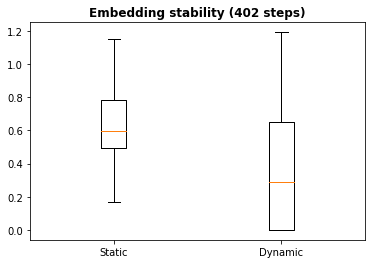

In [281]:
print(f'Static Embedding stability variance : {np.var(diff_list_embed_readers):.3f}')
print(f'Dynamic Embedding stability variance : {np.var(diff_list_embed_readers_lanc):.3f}')
plt.boxplot([diff_list_embed_readers, diff_list_embed_readers_lanc], labels=['Static', 'Dynamic'])
plt.title(f'Embedding stability ({len(diff_list_embed_readers)} steps)', weight='bold');

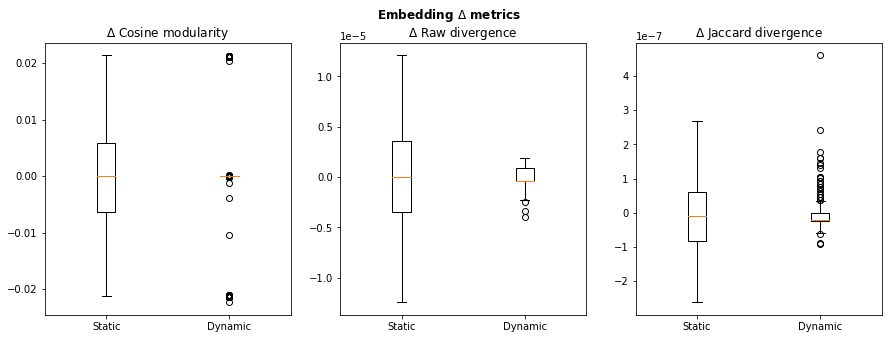

In [282]:
labs = ['Static', 'Dynamic']
met = ['Cosine modularity', 'Raw divergence', 'Jaccard divergence']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('Embedding $\Delta$ metrics', weight='bold')
ax[0].boxplot([delta_list_cosmod, delta_list_cosmod_lanc], labels=labs)
ax[1].boxplot([delta_list_raw_div, delta_list_raw_div_lanc], labels=labs)
ax[2].boxplot([delta_list_jaccard_div, delta_list_jaccard_div_lanc], labels=labs)
for i in range(3):
    ax[i].set_title('$\Delta$ ' + met[i])

#### 2.2.3 Lanczos with fixed initialization

The lanczos algorithm is initialized with a random vector which is the same all over iterations.

**Cosine modularity variance**

CPU times: user 1h 26min 53s, sys: 5min 35s, total: 1h 32min 29s
Wall time: 47min 31s


Text(0.5, 1.0, 'Cosine-modularity of spectral embedding space')

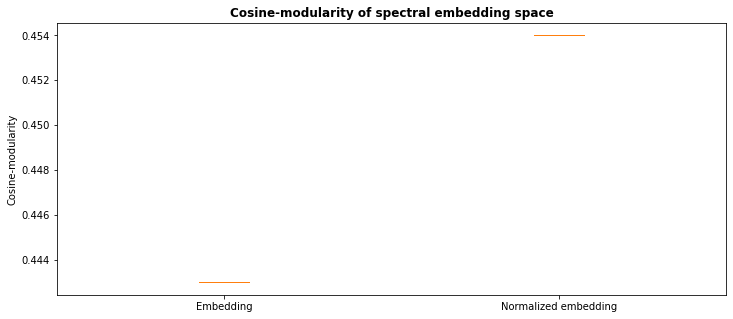

In [255]:
%%time

k = 20
cosmod_iter_list, cosmod_iter_list_norm = [], []

# Seed initialization
np.random.seed(1991)
v0_seed = np.random.rand(biadjacency.shape[0]+biadjacency.shape[1])

# 100 iterations
for i in range(100):
    spect = Spectral(k, normalized_laplacian=False, regularization=0, v0=v0_seed)
    spect_norm = Spectral(k, normalized_laplacian=True, regularization=0, v0=v0_seed)
    
    embed_rows = spect.fit_transform(biadjacency)
    embed_cols = spect.embedding_col_
    embed_rows_norm = spect_norm.fit_transform(biadjacency)
    embed_cols_norm = spect_norm.embedding_col_
    
    cosmod_iter_list.append(np.round(cosine_modularity(biadjacency, embedding=embed_rows, embedding_col=embed_cols), 3))
    cosmod_iter_list_norm.append(np.round(cosine_modularity(biadjacency, embedding=embed_rows_norm, embedding_col=embed_cols_norm), 3))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.boxplot([cosmod_iter_list, cosmod_iter_list_norm], labels=['Embedding', 'Normalized embedding'])
plt.ylabel('Cosine-modularity')
plt.title('Cosine-modularity of spectral embedding space', weight='bold');

In [290]:
k=20

list_cosmod_fix, list_raw_div_fix, list_jaccard_div_fix, list_v0 = [], [], [], []

# - Initial embedding -
init_biadjacency = goodReads.biadjacency
init_readers = goodReads.names
init_books = goodReads.names_col

# - Seed initialization -
np.random.seed(1991)
v0_seed_row = np.random.rand(biadjacency.shape[0])
np.random.seed(12)
v0_seed_col = np.random.rand(biadjacency.shape[1])
v0_seed = np.hstack([v0_seed_row, v0_seed_col])

init_bispectral_fix = Spectral(k, normalized_laplacian=True, regularization=0, v0=v0_seed)
init_embedding_readers_fix = init_bispectral_fix.fit_transform(init_biadjacency)
init_embedding_books_fix = init_bispectral_fix.embedding_col_

init_first_embed_readers = v0_seed_row
init_first_embed_books = v0_seed_col
list_v0.append(v0_seed)

In [291]:
%%time

# - Import Data -
goodReads = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train.csv', bipartite=True, fast_format=False)
goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', names=['reader', 'book', 'is_read'])
goodReads_new_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_test.csv', names=['reader', 'book', 'is_read'])

# - Initialization -
updated_df_fix = goodReads_df.copy()
updated_readers_fix = init_readers
updated_books_fix = init_books
updated_first_embed_readers = init_first_embed_readers
updated_first_embed_books = init_first_embed_books


# - Add new nodes -
list_biadjacency_fix, list_embed_readers_fix, diff_list_embed_readers_fix = [], [], []
for i in range(int(goodReads_new_df.shape[0]/10)):
    
    link = goodReads_new_df.iloc[i:i+1, :]
    updated_df_fix, new_source, new_target = add_link(updated_df_fix, link)
    
    # Previous step embedding vector
    if new_source != None:
        j = 0
        while updated_readers_fix[j] < new_source:
            j += 1
        updated_first_embed_readers = np.insert(updated_first_embed_readers, j, 0)
    if new_target != None:
        j = 0
        while updated_books_fix[j] < new_target:
            j += 1
        updated_first_embed_books = np.insert(updated_first_embed_books, j, 0)
    # Update v0 at time t-1 to fit with adjacency matrix at time t
    list_v0[i] = np.hstack([updated_first_embed_readers, updated_first_embed_books])
        
    # Update graph
    updated_graph_fix = sk.data.load_edge_list(f'{path}/updated_df.csv', bipartite=True, fast_format=False)
    
    # Update Embedding
    updated_biadjacency_fix = updated_graph_fix.biadjacency
    updated_readers_fix = updated_graph_fix.names
    updated_books_fix = updated_graph_fix.names_col

    updated_bispectral_fix = Spectral(k, 
                                       normalized_laplacian=True, 
                                       regularization=0, 
                                       v0=list_v0[i])
    updated_embedding_readers_fix = updated_bispectral_fix.fit_transform(updated_biadjacency_fix)    
    updated_embedding_books_fix = updated_bispectral_fix.embedding_col_
    
    # No updating on v0
    # updated_first_embed_readers = updated_embedding_readers_fix[:, 0]
    # updated_first_embed_books = updated_embedding_books_fix[:, 0]
    list_v0.append(np.hstack([updated_first_embed_readers, updated_first_embed_books]))
    
    
    # Update embedding metrics
    updated_cosine_mod_fix = cosine_modularity(updated_biadjacency_fix, 
                                                         embedding=updated_embedding_readers_fix, 
                                                         embedding_col=updated_embedding_books_fix)
    list_cosmod_fix.append(updated_cosine_mod_fix) # Fill cosine similarity list
    
    updated_raw_div_fix = raw_divergence(updated_biadjacency_fix,
                                         updated_embedding_readers_fix,
                                         updated_embedding_books_fix)
    list_raw_div_fix.append(updated_raw_div_fix) # Fill raw divergence list
    
    updated_jaccard_div_fix = jaccard_divergence(updated_biadjacency_fix,
                                         updated_readers_fix,
                                         updated_embedding_readers_fix)
    list_jaccard_div_fix.append(updated_jaccard_div_fix) # Fill jaccard divergence list
    
    #if i%100 == 0:
    #    list_biadjacency.append(updated_biadjacency)
    #    list_embed_readers.append(updated_embedding_readers_norm)
    list_biadjacency_fix.append(updated_biadjacency_fix)
    list_embed_readers_fix.append(updated_embedding_readers_fix)
    
    # Evalute stability
    if i > 0:
        # Froebinus norm between embedding at time t+1 and embedding at time t
        diff_list_embed_readers_fix.append(np.linalg.norm(list_embed_readers_fix[i] - list_embed_readers_fix[i-1], 
                                                      ord='fro'))

CPU times: user 10min 25s, sys: 1min 17s, total: 11min 43s
Wall time: 5min 43s


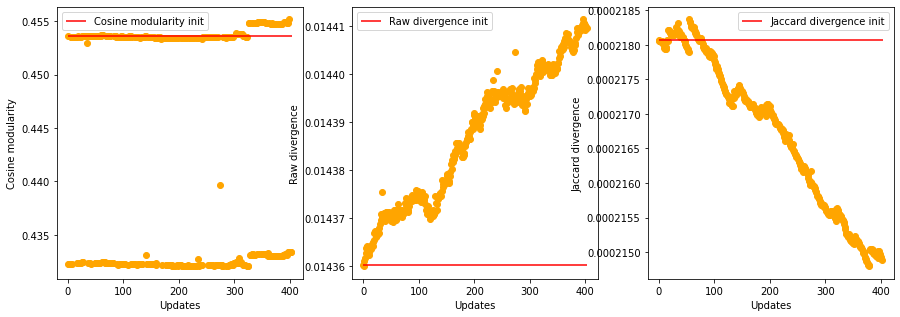

In [294]:
metrics = {'Cosine modularity':list_cosmod_fix, 
           'Raw divergence':list_raw_div_fix, 
           'Jaccard divergence':list_jaccard_div_fix}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    ax[idx].scatter(range(len(v)), v, color='orange')
    ax[idx].hlines(y=v[0], xmin=0, xmax=len(v), label=f'{k} init', color='r')
    ax[idx].set_xlabel('Updates')
    ax[idx].set_ylabel(f'{k}')
    ax[idx].legend(loc='best');

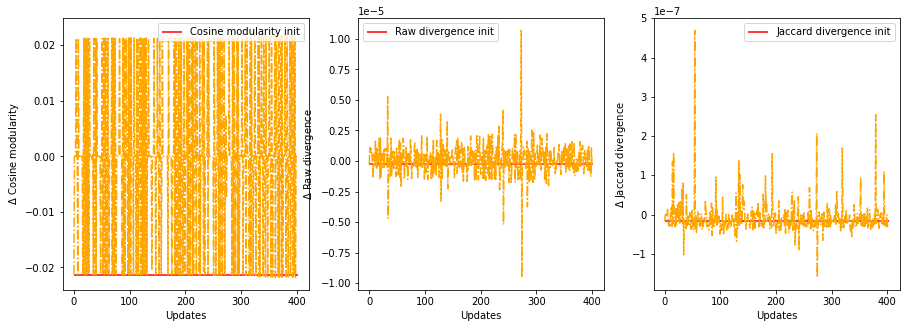

In [295]:
delta_list_cosmod_fix = np.array(list_cosmod_fix[1:]) - np.array(list_cosmod_fix[:-1])
delta_list_raw_div_fix = np.array(list_raw_div_fix[1:]) - np.array(list_raw_div_fix[:-1])
delta_list_jaccard_div_fix = np.array(list_jaccard_div_fix[1:]) - np.array(list_jaccard_div_fix[:-1])

metrics = {'Cosine modularity':delta_list_cosmod_fix, 
           'Raw divergence':delta_list_raw_div_fix, 
           'Jaccard divergence':delta_list_jaccard_div_fix}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    ax[idx].plot(range(len(v)), v, linestyle='dashdot', color='orange')
    ax[idx].hlines(y=v[0], xmin=0, xmax=len(v), label=f'{k} init', color='r')
    ax[idx].set_xlabel('Updates')
    ax[idx].set_ylabel(f'$\Delta$ {k}')
    ax[idx].legend(loc='best');

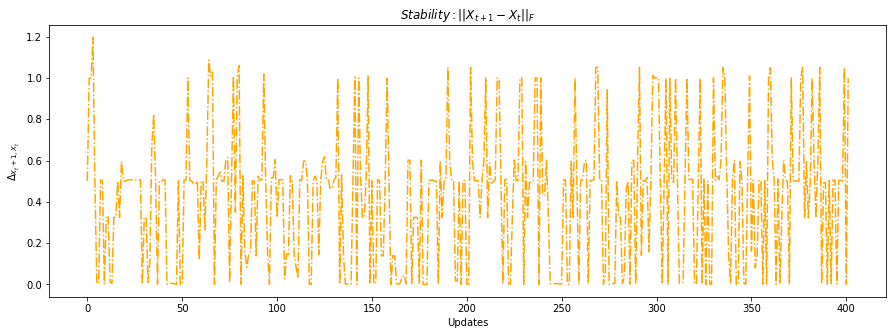

In [296]:
metrics = {'Stability':diff_list_embed_readers_fix}

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for idx, (k, v) in enumerate(metrics.items()):
    plt.plot(range(len(v)), v, linestyle='dashdot', color='orange')
    plt.xlabel('Updates')
    plt.ylabel('$\Delta_{X_t+1, X_t}$')
    plt.title('$Stability : ||X_{t+1} - X_{t}||_{F}$', weight='bold');

**Static vs dynamic embedding stability variance**

Static Embedding stability mean               : 0.644
Dynamic Embedding stability mean (fixed init) : 0.419
Dynamic Embedding stability mean              : 0.338


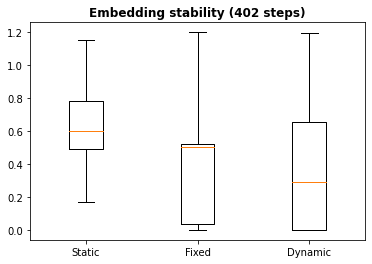

In [301]:
print(f'Static Embedding stability mean               : {np.mean(diff_list_embed_readers):.3f}')
print(f'Dynamic Embedding stability mean (fixed init) : {np.mean(diff_list_embed_readers_fix):.3f}')
print(f'Dynamic Embedding stability mean              : {np.mean(diff_list_embed_readers_lanc):.3f}')

plt.boxplot([diff_list_embed_readers, diff_list_embed_readers_fix, diff_list_embed_readers_lanc], 
            labels=['Static', 'Fixed', 'Dynamic'])
plt.title(f'Embedding stability ({len(diff_list_embed_readers)} steps)', weight='bold');

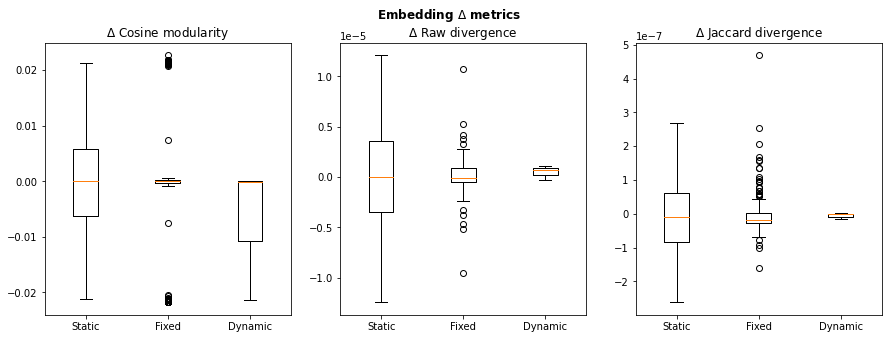

In [300]:
labs = ['Static', 'Fixed', 'Dynamic']
met = ['Cosine modularity', 'Raw divergence', 'Jaccard divergence']
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle('Embedding $\Delta$ metrics', weight='bold')
ax[0].boxplot([delta_list_cosmod, delta_list_cosmod_fix, delta_list_cosmod_lanc], labels=labs)
ax[1].boxplot([delta_list_raw_div, delta_list_raw_div_fix, delta_list_raw_div_lanc], labels=labs)
ax[2].boxplot([delta_list_jaccard_div, delta_list_jaccard_div_fix, delta_list_jaccard_div_lanc], labels=labs)
for i in range(len(met)):
    ax[i].set_title('$\Delta$ ' + met[i])

## 3 Machine Learning task

#### 3.1 Link prediction

Initial set of edges is divied into *training* and *test* sets, denoted $G_{train}$ and $G_{test}$ respectively.
For each edge in $G_{train}$, embedding $X_{t}$ is updated according to methods detailed above (i.e static or dynamic).
At the end of the training phase, the last embedding $X_{T_{train}}$ is used to compute similarity matrix $S$ (method detailed below). 

We predict **only the most likely** (i.e highest similarity) edges which are not in $G_{train}$, as the hidden edges. These predictions are compared to $G_{test}$ to compute **ROC AUC** score.

**Prediction method** : Unsupervised learning is chosen to predict missing edges on graph.   
Following the intuition that distance between vectors in the embedding space is related to a highest probability of having a link in the graph, we compute similarity between nodes $i$ and $j$ as $S(i, j) = |C(i, j)|$ with $C(x, y)=\dfrac{<x, y>}{||x||.||y||}$ the cosine similarity between vectors $x$ and $y$. 
In order to consider only the most likely edges, we set a threshold $\alpha$ under which $S(i, j)$ is considered to be equal to $0$.

In [374]:
def graph2edgelist(input_matrix: sparse.csr_matrix, names: np.ndarray, names_col: np.ndarray, data=True) -> list:
    ''' Return csr matrix in an edge-list format. Each edge is represented by a tuple (source, target, {data}).
        
        Parameters
        ----------
        input_matrix : 
            Adjacency matrix of the graph or csr matrix to convert (similarity matrix for example)
        names :
            Array of rows labels in adjacency matrix 
        names_col :
            Array of columns labels in adjacency matrix (if bipartite)
        data : Bool (default = `` True ``)
            If ``True`` returns a list of tuple (source, target, data), else returns a list of tuple (source, target)
            
        Returns
        -------
        edge_list : list
            A list of edges corresponding to input_matrix.
    '''

    edge_list = []
    
    if data:
        for row, indptr in enumerate(input_matrix.indptr[:-1]):
            for indice, data in zip(input_matrix.indices[input_matrix.indptr[row]:input_matrix.indptr[row+1]], input_matrix.data[input_matrix.indptr[row]:input_matrix.indptr[row+1]]):
                edge_list.append((names[row], names_col[indice], data))
    else:
        for row, indptr in enumerate(input_matrix.indptr[:-1]):
            for indice, data in zip(input_matrix.indices[input_matrix.indptr[row]:input_matrix.indptr[row+1]], input_matrix.data[input_matrix.indptr[row]:input_matrix.indptr[row+1]]):
                edge_list.append((names[row], names_col[indice]))
                
    return edge_list                

In [455]:
class EmbeddingCosineSimilarity():
    ''' Cosine similarity of an embedding, used to perform link prediction following the intuition that highest cosine similarity
        leads to higest probability to observe an edge between two nodes in the original network. The ``cosine_similarity()`` function from 
        ``scikit-klearn`` is used. By taking absolute values of result, metric values lie in :math:`[0, 1]`.
        
        Comparisons between similaritites and true_labels can be computed using ``predict`` function.
        
        Parameters
        ----------
            adjacency : 
                Adjacency matrix of graph used for embedding.
            names :
                Array of rows labels in adjacency matrix.
            names_col :
                Array of columns labels in adjacency matrix (if bipartite).
    '''
    
    def __init__(self, adjacency: Union[sparse.csr_matrix, np.ndarray], names: np.ndarray, names_col: np.ndarray):
        self.adjacency = adjacency
        self.names = names
        self.names_col = names_col
        
    def fit(self, embedding_rows: np.ndarray, embedding_cols: np.ndarray) -> np.ndarray:
        ''' Computes the cosine-similarity on embedding.
        
            Parameters
            ----------
                embedding_rows : array, shape = (n_row, n_components)
                    Embedding of the rows, for bipartite graphs.
                embedding_cols : array, shape = (n_col, n_components)
                    Embedding of the columns, for bipartite graphs.
            
            Returns
            -------
                cosine similarity matrix : array, shape = (n_row, n_col)
        '''
        cos_sim = cosine_similarity(embedding_rows, embedding_cols)
        return np.abs(cos_sim)
    
    def predict(self, similarities: np.ndarray, true_labels: list, alpha: int = 0) -> Tuple[np.ndarray, np.ndarray]:
        ''' Compares similarity matrix :math:``S`` with true labels.
            Similarities between nodes are considered only for the edges that were not used to build embedding. In addition, a threshold :math:``alpha``
            can be set to consider only the highest weighted edges. If :math:``alpha > 0``, forces all elements of :math:``S`` below :math:``alpha`` to 0.
        
            Parameters
            ----------
                similarities : array, shape = (n_row, n_col)
                    Cosine similarity matrix.
                true_labels : array
                    List of tuple representing edges (source, target).
                alpha : int
                    Threshold : if :math:``S(i,j)<alpha`` then :math:``S(i,j)=0``
            
            Returns
            -------
                scores : array
                    Similarity scores for each edge in ``true_labels``.
                labels : array of Bool
                    Contains ``True``if edge with high similarity score is indeed in ``true_labels``.
                    
        '''
        
        # Not considering edges coming from graph on which embedding is built
        similarities[tuple([(self.adjacency==1).todense()])] = 0
        
        # Not considering edges if similarity below threshold alpha
        similarities[tuple([(similarities < alpha)])] = 0
        
        similarities = sparse.csr_matrix(similarities)
        edge_list_similarities = graph2edgelist(similarities, self.names, self.names_col, data=True)
        
        scores, labels = zip(*[(s, (u, v) in true_labels) for (u, v, s) in edge_list_similarities])
        
        return np.array(scores), np.array(labels)

**$G_{test}$ definition**  
Hidden edges are stored in an edge list format in the `true_labs` variable.

In [375]:
graph_test = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_test.csv', bipartite=True, fast_format=False)
biadjacency_test = graph_test.biadjacency
names_test = graph_test.names
names_col_test = graph_test.names_col

true_labs = graph2edgelist(biadjacency_test, names_test, names_col_test, data=False)

**Static embedding on $G_{train}$** (Lanczos vector randomly initialized at each step $t$)

In [478]:
%%time

k = 20 # Embedding space dimension

# - Import Data -
goodReads1 = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train1.csv', bipartite=True, fast_format=False)
goodReads_df1 = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train1.csv', names=['reader', 'book', 'is_read'])
goodReads_eval_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_eval.csv', names=['reader', 'book', 'is_read'])

# - Initial embedding -
init_biadjacency = goodReads1.biadjacency
init_readers = goodReads1.names
init_books = goodReads1.names_col

init_bispectral_norm = Spectral(k, normalized_laplacian=True, regularization=0)
init_embedding_readers_norm = init_bispectral_norm.fit_transform(init_biadjacency)
init_embedding_books_norm = init_bispectral_norm.embedding_col_

# - Initialization -
updated_df = goodReads_df1.copy()

# - Add new nodes -
list_biadjacency, list_embed_readers, diff_list_embed_readers = [], [], []
for i in range(int(goodReads_eval_df.shape[0]/1)):
    
    link = goodReads_eval_df.iloc[i:i+1, :]
    updated_df, _, _ = add_link(updated_df, link)
        
    # Update graph
    updated_graph = sk.data.load_edge_list(f'{path}/updated_df.csv', bipartite=True, fast_format=False)
    
    # Update Embedding
    updated_biadjacency = updated_graph.biadjacency
    updated_readers = updated_graph.names
    updated_books = updated_graph.names_col
    
    updated_bispectral_norm = Spectral(k, normalized_laplacian=True, regularization=0)
    updated_embedding_readers_norm = updated_bispectral_norm.fit_transform(updated_biadjacency)
    updated_embedding_books_norm = updated_bispectral_norm.embedding_col_
    
# Embedding cosine similarity
ecs = EmbeddingCosineSimilarity(updated_biadjacency, updated_readers, updated_books)
simil = ecs.fit(updated_embedding_readers_norm, updated_embedding_books_norm)

# Predictions
scores_stat, labels_stat = ecs.predict(simil, true_labs, alpha=0.8)

CPU times: user 1h 7min 7s, sys: 6min 15s, total: 1h 13min 23s
Wall time: 38min 1s


**Dynamic embedding on $G_{train}$**

In [479]:
%%time

k = 20 # Embedding space dimension

# - Import Data -
goodReads1 = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train1.csv', bipartite=True, fast_format=False)
goodReads_df1 = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train1.csv', names=['reader', 'book', 'is_read'])
goodReads_eval_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_eval.csv', names=['reader', 'book', 'is_read'])

# - Initial embedding -
init_biadjacency = goodReads1.biadjacency
init_readers = goodReads1.names
init_books = goodReads1.names_col

init_bispectral_lanc = Spectral(k, normalized_laplacian=True, regularization=0, v0=None) # First embedding is initialized randomly
init_embedding_readers_lanc = init_bispectral_lanc.fit_transform(init_biadjacency)
init_embedding_books_lanc = init_bispectral_lanc.embedding_col_

# Store first eigenvector for embedding at t-1
books_embedding_dic = {book:init_embedding_books_lanc[idx, 0] for idx, book in enumerate(init_books)}
readers_embedding_dic = {reader:init_embedding_readers_lanc[idx, 0] for idx, reader in enumerate(init_readers)}

# - Initialization -
updated_df_lanc = goodReads_df1.copy()
updated_readers_lanc = init_readers
updated_books_lanc = init_books

# - Add new nodes -
list_biadjacency_lanc, list_embed_readers_lanc, diff_list_embed_readers_lanc = [], [], []
for i in range(int(goodReads_eval_df.shape[0]/1)):
    
    link = goodReads_eval_df.iloc[i:i+1, :]
    updated_df_lanc, new_source, new_target = add_link(updated_df_lanc, link)
    
    # Previous step embedding vector
    if new_source != None:
        readers_embedding_dic[new_source] = 0
    if new_target != None:
        books_embedding_dic[new_target] = 0

    # Update training graph
    updated_graph_lanc = sk.data.load_edge_list(f'{path}/updated_df.csv', bipartite=True, fast_format=False)
    updated_biadjacency_lanc = updated_graph_lanc.biadjacency
    updated_readers_lanc = updated_graph_lanc.names
    updated_books_lanc = updated_graph_lanc.names_col
    
    # Build v0 for training graph with previous embedding value if nodes existed at t-1
    updated_v0_source = np.array([readers_embedding_dic[source] for source in updated_readers_lanc])
    updated_v0_target = np.array([books_embedding_dic[target] for target in updated_books_lanc])
    updated_v0 = np.hstack([updated_v0_source, updated_v0_target])
    
    # Update Embedding
    updated_bispectral_lanc = Spectral(k, 
                                       normalized_laplacian=True, 
                                       regularization=0, 
                                       v0=updated_v0)
    updated_embedding_readers_lanc = updated_bispectral_lanc.fit_transform(updated_biadjacency_lanc)    
    updated_embedding_books_lanc = updated_bispectral_lanc.embedding_col_
    
    # Update embedding dictionaries at time t with new embedding information
    for idx, source in enumerate(updated_readers_lanc):
        readers_embedding_dic[source] = updated_embedding_readers_lanc[idx, 0]
    for idx, target in enumerate(updated_books_lanc):
        books_embedding_dic[target] = updated_embedding_books_lanc[idx, 0]
    
    
# Embedding cosine similarity
ecs = EmbeddingCosineSimilarity(updated_biadjacency_lanc, updated_readers_lanc, updated_books_lanc)
simil = ecs.fit(updated_embedding_readers_lanc, updated_embedding_books_lanc)

# Predictions
scores_dyn, labels_dyn = ecs.predict(simil, true_labs, alpha=0.8)

print(f'{i} iterations')

3225 iterations
CPU times: user 1h 6min 48s, sys: 6min 7s, total: 1h 12min 55s
Wall time: 38min 3s


**ROC AUC**

In [485]:
# LIST INITIALIZATION !
fpr_stat_list, tpr_stat_list, fpr_dyn_list, tpr_dyn_list = [], [], [], []
auc_stat_list, auc_dyn_list = [], []

In [480]:
# Compute ROC AUC Score
fpr_stat, tpr_stat, _ = roc_curve(labels_stat, scores_stat)
auc_stat = roc_auc_score(labels_stat, scores_stat)

fpr_dyn, tpr_dyn, _ = roc_curve(labels_dyn, scores_dyn)
auc_dyn = roc_auc_score(labels_dyn, scores_dyn)

In [481]:
fpr_stat_list.append(fpr_stat)
tpr_stat_list.append(tpr_stat)
auc_stat_list.append(auc_stat)
fpr_dyn_list.append(fpr_dyn)
tpr_dyn_list.append(tpr_dyn)
auc_dyn_list.append(auc_dyn)

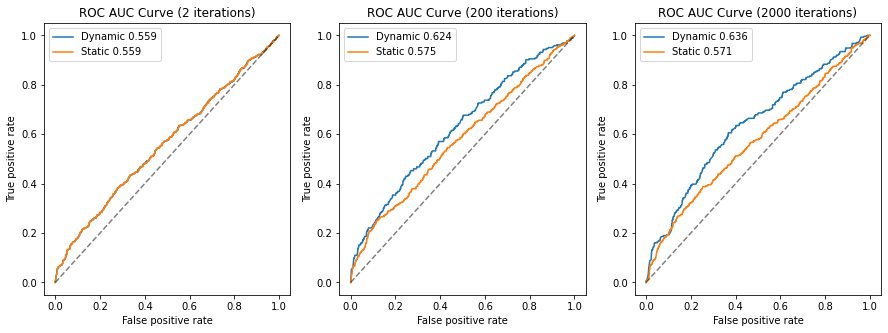

In [484]:
#iterations = [3, 400, 4000]
iterations = [2, 200, 2000]

# Plot
fig, ax = plt.subplots(1, len(iterations), figsize=(15, 5))
for i in range(len(iterations)):
    ax[i].plot(fpr_dyn_list[i], tpr_dyn_list[i], label=f'Dynamic {auc_dyn_list[i]:.3f}')
    ax[i].plot(fpr_stat_list[i], tpr_stat_list[i], label=f'Static {auc_stat_list[i]:.3f}')
    ax[i].plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
    ax[i].set_xlabel('False positive rate')
    ax[i].set_ylabel('True positive rate')
    ax[i].set_title(f'ROC AUC Curve ({iterations[i]} iterations)')
    ax[i].legend();

In [486]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Annexes

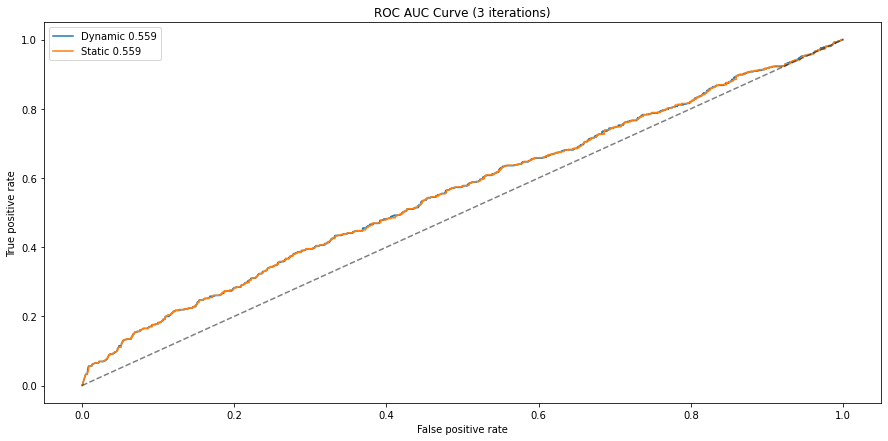

In [468]:
# Plot
fig, ax = plt.subplots(1, len(iterations), figsize=(15, 7))
for i in range(len(iterations)):
    plt.plot(fpr_dyn_list[i], tpr_dyn_list[i], label=f'Dynamic {auc_dyn_list[i]:.3f}')
    plt.plot(fpr_stat_list[i], tpr_stat_list[i], label=f'Static {auc_stat_list[i]:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC AUC Curve ({iterations[i]} iterations)')
    plt.legend();

In [55]:
def add_link_train_test(df, link):
    
    new_source, new_target = None, None
    
    if link.iloc[0, 0] not in df.iloc[:, 0].values:
        new_source = link.iloc[0, 0]
    if link.iloc[0, 1] not in df.iloc[:, 1].values:
        new_target = link.iloc[0, 1]
        
    updated_df_train, updated_df_test = train_test_split(pd.concat([df, link], axis=0), test_size=0.15) # Hide 15% of edges
    updated_df_train.to_csv(f'{path}/updated_df_train.csv', index=False, header=False)
    updated_df_test.to_csv(f'{path}/updated_df_test.csv', index=False, header=False)

    return updated_df_train, updated_df_test, new_source, new_target

**Similarities**  

Similarity matrix $S$ is updated to consider threshold $\alpha$. This allows to create a **sparse** matrix and thus speed up computations.

In [325]:
# - Predictions - 

alpha = 0.8

similarities_stat = link_prob_stat.copy()

# Not considering edges that come from training graph
similarities_stat[tuple([(updated_biadjacency==1).todense()])] = 0

# Not considering similarities below threshold alpha
similarities_stat[tuple([(similarities_stat<alpha)])] = 0

# Now that similarity matrix is sparse, convert to CSR format
similarities_stat = sparse.csr_matrix(similarities_stat)

# Build predictions edge list from similarity matrix
edge_list_pred_stat = []

for row, indptr in enumerate(similarities_stat.indptr[:-1]):
    for indice, data in zip(similarities_stat.indices[similarities_stat.indptr[row]:similarities_stat.indptr[row+1]], similarities_stat.data[similarities_stat.indptr[row]:similarities_stat.indptr[row+1]]):
        edge_list_pred_stat.append((updated_readers[row], updated_books[indice], data))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 11254 but corresponding boolean dimension is 11493

**Similarities**  

Similarity matrix $S$ is updated to consider threshold $\alpha$. This allows to create a **sparse** matrix and thus speed up computations.

In [ ]:
# - Predictions - 

alpha = 0.8

similarities_dyn = link_prob_dyn.copy()

# Not considering edges that come from training graph
similarities_dyn[tuple([(updated_biadjacency_lanc==1).todense()])] = 0

# Not considering similarities below threshold alpha
similarities_dyn[tuple([(similarities_dyn<alpha)])] = 0

# Now that similarity matrix is sparse, convert to CSR format
similarities_dyn = sparse.csr_matrix(similarities_dyn)

# Build predictions edge list from similarity matrix
edge_list_pred_dyn = []

for row, indptr in enumerate(similarities_dyn.indptr[:-1]):
    for indice, data in zip(similarities_dyn.indices[similarities_dyn.indptr[row]:similarities_dyn.indptr[row+1]], similarities_dyn.data[similarities_dyn.indptr[row]:similarities_dyn.indptr[row+1]]):
        edge_list_pred_dyn.append((updated_readers_lanc[row], updated_books_lanc[indice], data))

**$G_{test}$ initilization**  

We build edge list from $G_{test}$.

In [ ]:
%%time

graph_test = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_test.csv', bipartite=True, fast_format=False)
biadjacency_test = graph_test.biadjacency
names_test = graph_test.names
names_col_test = graph_test.names_col
edge_list_test = []

for row, indptr in enumerate(graph_test.biadjacency.indptr[:-1]):
    for col in graph_test.biadjacency.indices[graph_test.biadjacency.indptr[row]:graph_test.biadjacency.indptr[row+1]]:
        edge_list_test.append((names_test[row], names_col_test[col]))

**Predictions**  
Similarity scores computed on embedding are compared to $G_{test}$.

In [ ]:
%%time
scores_dyn, labels_dyn = zip(*[(s, (u, v) in edge_list_test) for (u, v, s) in edge_list_pred_dyn])
scores_stat, labels_stat = zip(*[(s, (u, v) in edge_list_test) for (u, v, s) in edge_list_pred_stat])